# Modifying images to get a larger dataset

In [1]:
# load libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import os
import sys
import argparse
import re
import glob
import matplotlib
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from matplotlib import rcParams
from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
from matplotlib import colors
from matplotlib import colorbar
from matplotlib import patches
from matplotlib import lines
from matplotlib import gridspec
from matplotlib import ticker
from matplotlib import transforms
from matplotlib import font_manager
from matplotlib import animation
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import dates
from PIL import Image, ImageEnhance, ImageFilter, ImageDraw
import cv2

In [37]:
class ImageAugmentation:
    def __init__(self, image_path):
        self.image = Image.open(image_path)
        self.base_name = os.path.splitext(os.path.basename(image_path))[0]
        self.output_dir = './images/augmented_images'
        os.makedirs(self.output_dir, exist_ok=True)

    def bezier_curve(self, p0, p1, p2, t):
        """Calculate a point on a quadratic Bezier curve."""
        return (
            (1 - t) ** 2 * p0[0] + 2 * (1 - t) * t * p1[0] + t ** 2 * p2[0],
            (1 - t) ** 2 * p0[1] + 2 * (1 - t) * t * p1[1] + t ** 2 * p2[1]
        )

    def draw_bezier_curve(self, draw, p0, p1, p2, color, thickness):
        """Draw a quadratic Bezier curve using line segments."""
        steps = 100  # Number of steps for approximation
        prev_point = self.bezier_curve(p0, p1, p2, 0)
        for i in range(1, steps + 1):
            t = i / steps
            current_point = self.bezier_curve(p0, p1, p2, t)
            draw.line([prev_point, current_point], fill=color, width=thickness)
            prev_point = current_point

    def save_image(image, output_path):
        # Save the modified image to the specified path
        image.save(output_path)

    def adjust_brightness(self, factor):
        enhancer = ImageEnhance.Brightness(self.image)
        out = enhancer.enhance(factor)
        out.save(os.path.join(self.output_dir, f"{self.base_name}_bright.jpg"))

    def adjust_contrast(self, factor):
        enhancer = ImageEnhance.Contrast(self.image)
        out = enhancer.enhance(factor)
        out.save(os.path.join(self.output_dir, f"{self.base_name}_contrast.jpg"))

    def adjust_saturation(self, factor):
        enhancer = ImageEnhance.Color(self.image)
        out = enhancer.enhance(factor)
        out.save(os.path.join(self.output_dir, f"{self.base_name}_saturated.jpg"))

    def add_gaussian_noise(self, mean=0, var=0.1):
        img = np.array(self.image)
        row, col, ch = img.shape
        sigma = var**0.5
        gauss = np.random.normal(mean, sigma, (row, col, ch))
        noisy = img + gauss
        noisy_image = np.clip(noisy, 0, 255).astype(np.uint8)
        Image.fromarray(noisy_image).save(os.path.join(self.output_dir, f"{self.base_name}_noisy.jpg"))

    def blur_image(self, radius=2):
        out = self.image.filter(ImageFilter.GaussianBlur(radius))
        out.save(os.path.join(self.output_dir, f"{self.base_name}_blurred.jpg"))

    def add_curved_lines(self, num_lines=5, thickness=3):
        image = self.image.convert("RGBA")
        width, height = image.size
        overlay = Image.new("RGBA", (width, height), (255, 255, 255, 0))
        draw = ImageDraw.Draw(overlay)

        for _ in range(num_lines):
            p0 = (random.randint(0, width), random.randint(0, height))
            p1 = (random.randint(0, width), random.randint(0, height))
            p2 = (random.randint(0, width), random.randint(0, height))
            line_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255), random.randint(150, 255))
            
            # Draw the Bezier curve
            self.draw_bezier_curve(draw, p0, p1, p2, line_color, thickness)

        return Image.alpha_composite(image, overlay).convert("RGB")

    def add_straight_lines(self, num_lines=5, thickness=3):
        image = self.image.convert("RGBA")
        width, height = image.size
        overlay = Image.new("RGBA", (width, height), (255, 255, 255, 0))
        draw = ImageDraw.Draw(overlay)

        for _ in range(num_lines):
            x1, y1 = random.randint(0, width), random.randint(0, height)
            x2, y2 = random.randint(0, width), random.randint(0, height)
            line_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255), random.randint(150, 255))
            draw.line((x1, y1, x2, y2), fill=line_color, width=thickness)

        return Image.alpha_composite(image, overlay).convert("RGB")

    def add_lines(self, num_lines=5, thickness=3, ratio_curved=0.5, color=(0, 0, 0), count=0):
        image = self.image.convert("RGBA")
        width, height = image.size
        overlay = Image.new("RGBA", (width, height), (255, 255, 255, 0))
        draw = ImageDraw.Draw(overlay)

        for _ in range(num_lines):

            # random color (black with random alpha)
            color_random_alpha = color + (random.randint(150, 255),)
            # color_random_alpha = color
            thickness_random = random.randint(1, thickness)

            if random.random() < ratio_curved:
                p0 = (random.randint(0, width), random.randint(0, height))
                p1 = (random.randint(0, width), random.randint(0, height))
                p2 = (random.randint(0, width), random.randint(0, height))
                line_color = color_random_alpha
                
                # Draw the Bezier curve
                self.draw_bezier_curve(draw, p0, p1, p2, line_color, thickness_random)
            else:
                x1, y1 = random.randint(0, width), random.randint(0, height)
                x2, y2 = random.randint(0, width), random.randint(0, height)
                line_color = color_random_alpha

                draw.line((x1, y1, x2, y2), fill=line_color, width=thickness_random)

        combined_image = Image.alpha_composite(image, overlay)
        combined_image.convert("RGB").save(os.path.join(self.output_dir, f"{self.base_name}_lines_{count}.jpg"))

    def create_all_images(self):
        self.adjust_brightness(1.5)
        self.adjust_contrast(1.5)
        self.adjust_saturation(1.5)
        self.add_gaussian_noise(mean=0, var=30)
        self.blur_image(radius=1)
        for i in range(50):
            amount_of_lines = random.randint(1, 20)
            ratio_curved = random.uniform(0, 1)
            self.add_lines(num_lines=amount_of_lines, thickness=3, ratio_curved=ratio_curved, color=(0, 0, 0), count=i)

In [38]:
# create variations of the image
image1 = ImageAugmentation('./images/test_modifying/AA-s.jpg')

# Adjust brightness
image1.create_all_images()

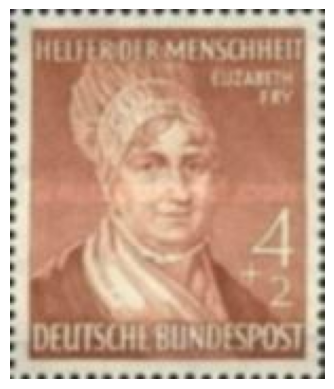

AA-s_blurred.jpg
---------------------------------


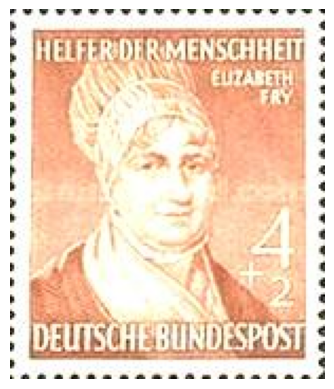

AA-s_bright.jpg
---------------------------------


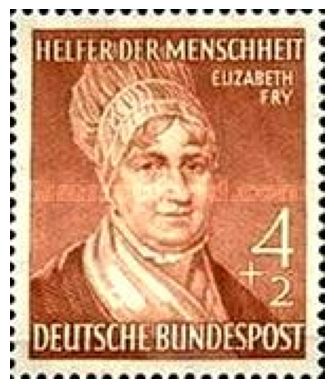

AA-s_contrast.jpg
---------------------------------


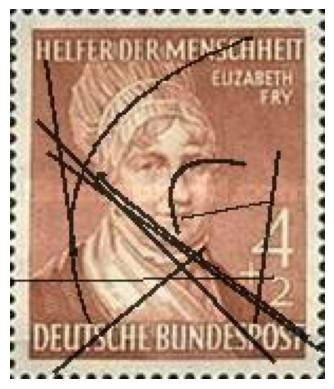

AA-s_lines.jpg
---------------------------------


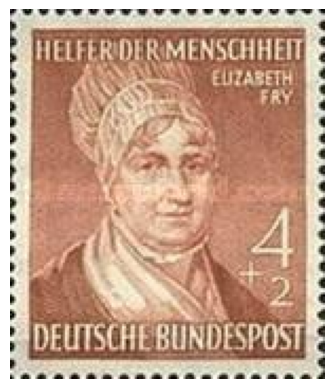

AA-s_noisy.jpg
---------------------------------


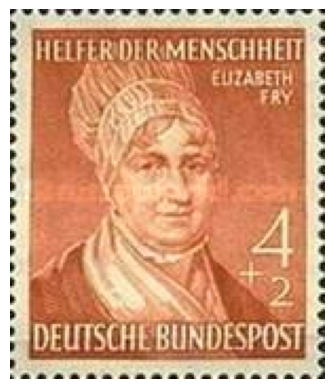

AA-s_saturated.jpg
---------------------------------


In [5]:
# load all file from folder ./images/test_modifying/ and display them
path = './images/augmented_images'
files = os.listdir(path)
files.sort()
for file in files:
    image = cv2.imread(os.path.join(path, file))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    plt.close()
    print(file)
    print('---------------------------------')


https://chatgpt.com/share/ac9e8738-b114-49d0-b1cb-eaefc639ca73